In [1]:
import pandas as pd
data = pd.read_csv("operations.csv",parse_dates=[1,2])
print(data)

     identifiant_transaction date_operation date_valeur  \
0                        242     2023-10-06  2023-10-06   
1                         25     2023-10-06  2023-10-06   
2                         69     2023-10-06  2023-10-06   
3                        299     2023-10-05  2023-10-05   
4                         45     2023-10-05  2023-10-05   
..                       ...            ...         ...   
303                      295     2023-04-03  2023-04-03   
304                      221     2023-04-03  2023-04-03   
305                      205     2023-04-03  2023-04-03   
306                       50     2023-04-03  2023-04-03   
307                      108     2023-03-31  2023-03-31   

                                          libelle  debit  credit    solde  
0            FORFAIT COMPTE SUPERBANK XX XX XX XX  -1.92     NaN  2513.79  
1                         CARTE XX XX CHEZ LUC XX -10.00     NaN  2529.29  
2                  PRELEVEMENT XX TELEPHONE XX XX -13.58     Na

In [2]:
data.columns = ['identifiant_transaction','date_operation','date_valeur',
                'libelle','debit','credit','solde']

In [3]:
from collections import Counter

def most_common_words(labels):
    words = []
    for lab in labels:
        words += lab.split(" ")
    counter = Counter(words)
    for word in counter.most_common(100):
        print(word)

most_common_words(data['libelle'].values)

('XX', 1428)
('CARTE', 247)
('VIREMENT', 29)
('LES', 20)
('ANCIENS', 20)
('ROBINSON', 20)
('CHEZ', 16)
('LUC', 16)
('LA', 16)
("L'EPICERIE", 16)
('DEMBAS', 16)
('TOUPTIPRI', 12)
('CCNCF', 9)
('RETRAIT', 9)
('PRELEVEMENT', 8)
('RAPT', 8)
('FORFAIT', 7)
('COMPTE', 7)
('SUPERBANK', 7)
('TELEPHONE', 7)
('DON', 7)
('LOUVE', 7)
('PERMANENT', 6)
('LOYER', 6)
('VELOC', 4)


In [4]:
CATEGS = {
    'LOYER': 'LOYER',
    'FORFAIT COMPTE SUPERBANK': 'COTISATION BANCAIRE',
    'LES ANCIENS ROBINSON': 'COURSES',
    "L'EPICERIE DENBAS": 'COURSES',
    'TELEPHONE': 'FACTURE TELEPHONE',
    'LA CCNCF': 'TRANSPORT',
    'CHEZ LUC': 'RESTAURANT',
    'RAPT': 'TRANSPORT',
    'TOUPTIPRI': 'COURSES',
    'LA LOUVE': 'COURSES',
    'VELOC': 'TRANSPORT'
}
TYPES = {
    'CARTE': 'CARTE',
    'VIR': 'VIREMENT',
    'VIREMENT': 'VIREMENT',
    'RETRAIT': 'RETRAIT',
    'PRLV': 'PRELEVEMENT',
    'DON': 'DON',
}

In [5]:
EXPENSES = [80,200] # Bornes des catégories de dépense : petite, moyenne et grosse
LAST_BALANCE = 2400 # Solde du compte APRES la dernière opération en date
WEEKEND = ["Saturday","Sunday"] # Jours non travaillés

In [6]:
# Controle des colonnes
for c in ['date_operation','libelle','debit','credit']:
    if c not in data.columns:
        if (c in ['debit','credit'] and 'montant' not in data.columns) or \
        (c not in ['debit','credit']):
            msg = "Il vous manque la colonne '{}'. Attention aux majuscules "
            msg += "et minuscules dans le nom des colonnes!"
            raise Exception(msg.format(c))

# Suppression des colonnes innutiles
for c in data.columns:
    if c not in ['date_operation','libelle','debit','credit','montant']:
        del data[c]

# Ajout de la colonne 'montant' si besoin
if 'montant' not in data.columns:
    data["debit"] = data["debit"].fillna(0)
    data["credit"] = data["credit"].fillna(0)
    data["montant"] = data["debit"] + data["credit"]
    del data["credit"], data["debit"]

# creation de la variable 'solde_avt_ope'
data = data.sort_values("date_operation")
amount = data["montant"]
balance = amount.cumsum()
balance = list(balance.values)
last_val = balance[-1]
balance = [0] + balance[:-1]
balance = balance - last_val + LAST_BALANCE
data["solde_avt_ope"] = balance

# Assignation des operations a une categorie et a un type
def detect_words(values, dictionary):
    result = []
    for lib in values:
        operation_type = "AUTRE"
        for word, val in dictionary.items():
            if word in lib:
                operation_type = val
        result.append(operation_type)
    return result
data["categ"] = detect_words(data["libelle"], CATEGS)
data["type"] = detect_words(data["libelle"], TYPES)

# creation des variables 'tranche_depense' et 'sens'
def expense_slice(value):
    value = -value # Les dépenses sont des nombres négatifs
    if value < 0:
        return "(pas une dépense)"
    elif value < EXPENSES[0]:
        return "petite"
    elif value < EXPENSES[1]:
        return "moyenne"
    else:
        return "grosse"
data["tranche_depense"] = data["montant"].map(expense_slice)
data["sens"] = ["credit" if m > 0 else "debit" for m in data["montant"]]

# Creation des autres variables
data["annee"] = data["date_operation"].map(lambda d: d.year)
data["mois"] = data["date_operation"].map(lambda d: d.month)
data["jour"] = data["date_operation"].map(lambda d: d.day)
data["jour_sem"] = data["date_operation"].map(lambda d: d.day_name)
data["jour_sem_num"] = data["date_operation"].map(lambda d: d.weekday()+1)
data["weekend"] = data["jour_sem"].isin(WEEKEND)
data["quart_mois"] = [int((jour-1)*4/31)+1 for jour in data["jour"]]
        
# Enregistrement au format CSV
data.to_csv("operations_enrichies.csv",index=False)

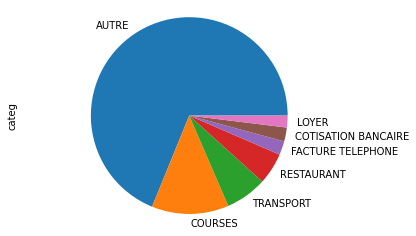

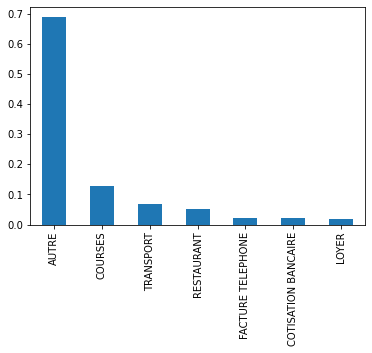

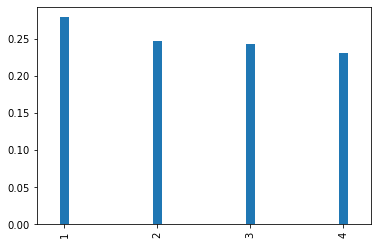

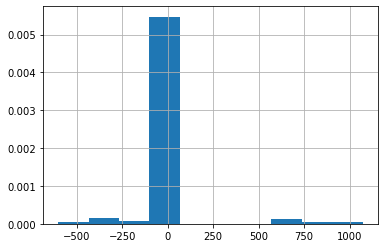

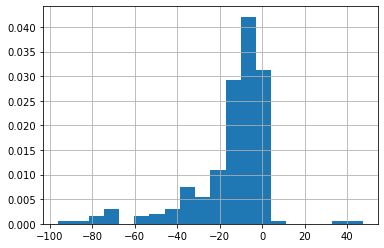

In [7]:
import matplotlib.pyplot as plt

# VARIABLE QUALITATIVE
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()

# VARIABLE QUANTITATIVE
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

# Histogramme
data["montant"].hist(density=True)
plt.show()
# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

In [8]:
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab = pd.DataFrame(modalites, columns = ["quart_mois"]) # création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon

In [9]:
tab = tab.sort_values("quart_mois") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée

In [10]:
data['montant'].mean()
data['montant'].median()
data['montant'].mode()

0   -1.6
dtype: float64

--------------------
AUTRE
moy:
 23.433207547169832
med:
 -8.31
mod:
 0   -1.6
dtype: float64


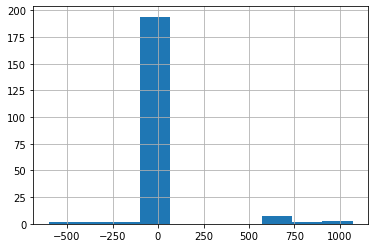

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
dtype: float64


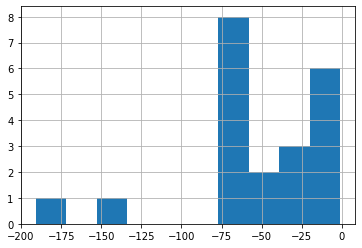

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
dtype: float64


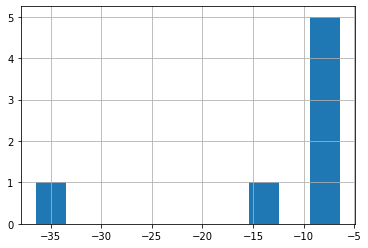

--------------------
COURSES
moy:
 -16.341282051282054
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
dtype: float64


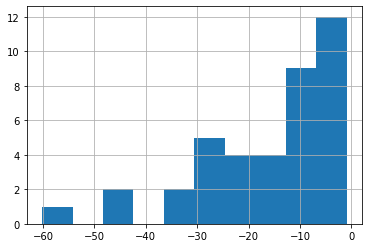

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
dtype: float64


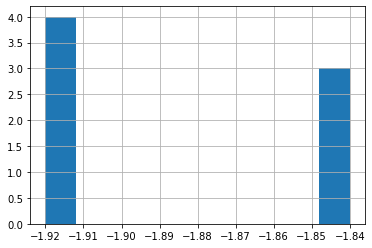

--------------------
RESTAURANT
moy:
 -10.332500000000001
med:
 -10.1
mod:
 0   -9.2
dtype: float64


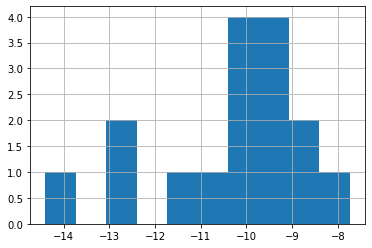

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
dtype: float64


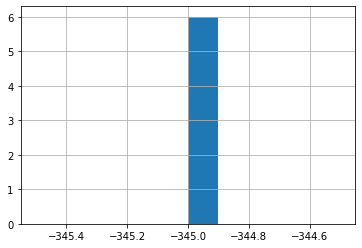

In [11]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat] # Création du sous-échantillon
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    subset["montant"].hist() # Crée l'histogramme
    plt.show() # Affiche l'histogramme

--------------------
AUTRE
moy:
 23.433207547169832
med:
 -8.31
mod:
 0   -1.6
dtype: float64
var:
 40401.82999254187
ect:
 201.00206464746046


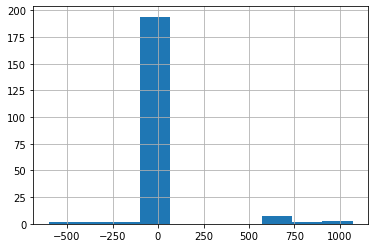

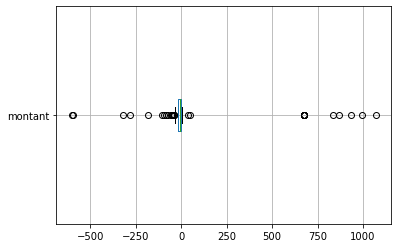

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
dtype: float64
var:
 2205.016868027212
ect:
 46.95760713694014


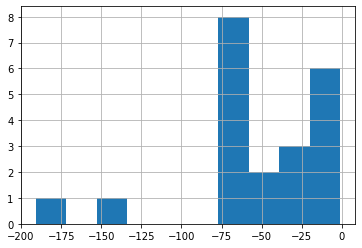

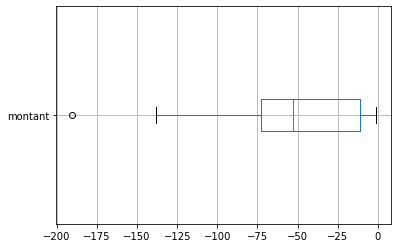

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
dtype: float64
var:
 105.01905306122445
ect:
 10.247880417980317


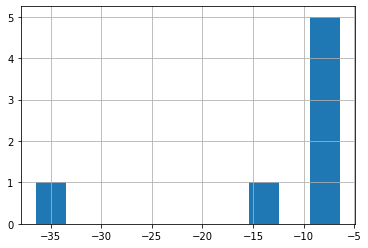

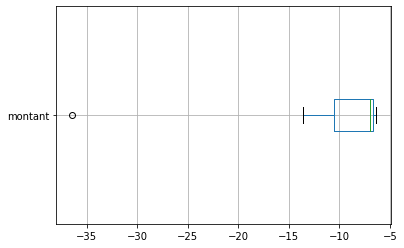

--------------------
COURSES
moy:
 -16.341282051282054
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
dtype: float64
var:
 177.0253547666009
ect:
 13.3050875520081


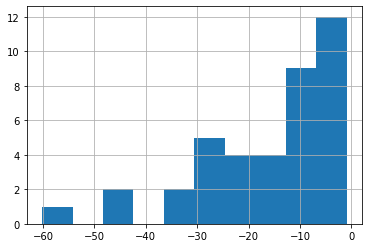

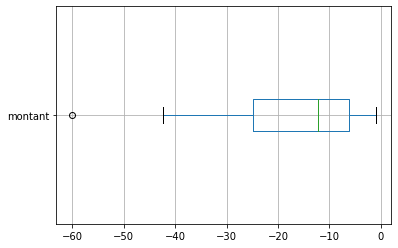

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
dtype: float64
var:
 0.0015673469387755044
ect:
 0.03958973274443141


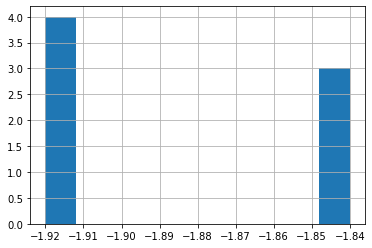

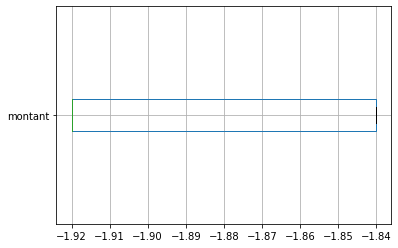

--------------------
RESTAURANT
moy:
 -10.332500000000001
med:
 -10.1
mod:
 0   -9.2
dtype: float64
var:
 2.853193750000001
ect:
 1.689139943876765


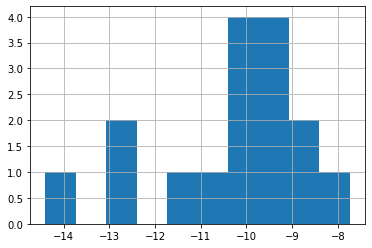

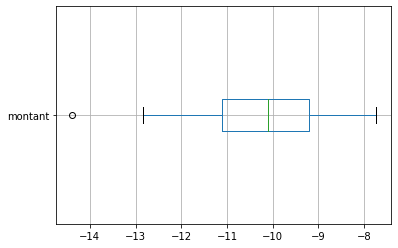

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
dtype: float64
var:
 0.0
ect:
 0.0


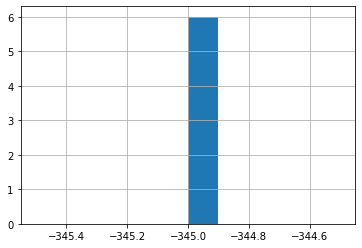

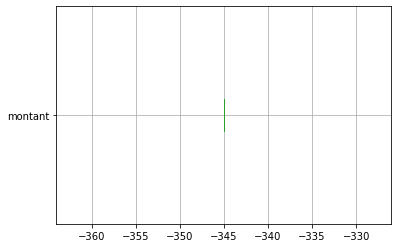

In [12]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

--------------------
AUTRE
moy:
 23.433207547169832
med:
 -8.31
mod:
 0   -1.6
dtype: float64
var:
 40401.82999254187
ect:
 201.00206464746046
skw:
 3.1215325222336427
kur:
 12.716537970826296


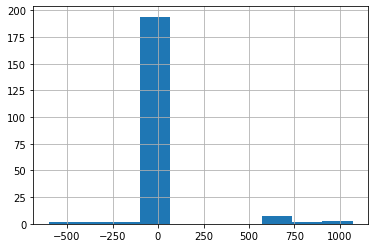

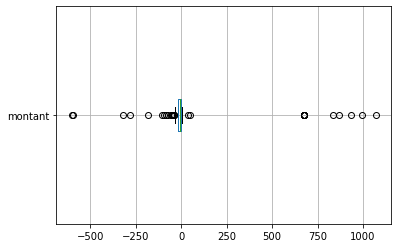

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
dtype: float64
var:
 2205.016868027212
ect:
 46.95760713694014
skw:
 -1.248265076217821
kur:
 2.1922705326917487


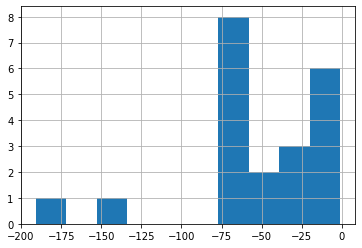

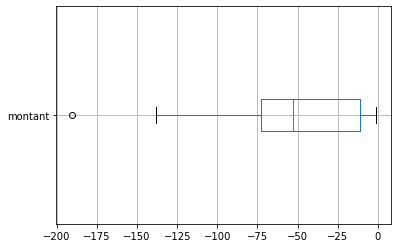

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
dtype: float64
var:
 105.01905306122445
ect:
 10.247880417980317
skw:
 -2.3876514564281526
kur:
 5.798563367885492


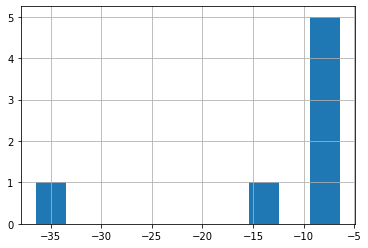

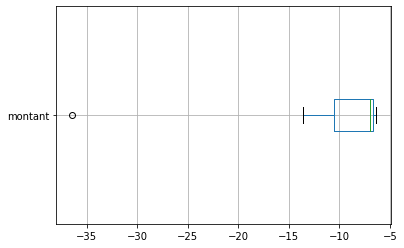

--------------------
COURSES
moy:
 -16.341282051282054
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
dtype: float64
var:
 177.0253547666009
ect:
 13.3050875520081
skw:
 -1.246748830645698
kur:
 1.604730494087499


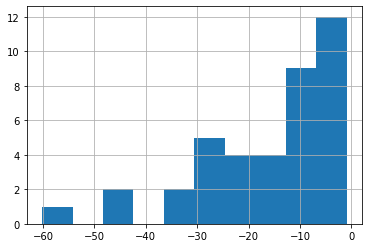

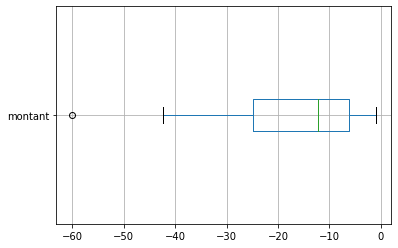

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
dtype: float64
var:
 0.0015673469387755044
ect:
 0.03958973274443141
skw:
 0.37416573867739106
kur:
 -2.800000000000003


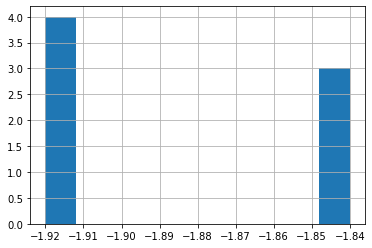

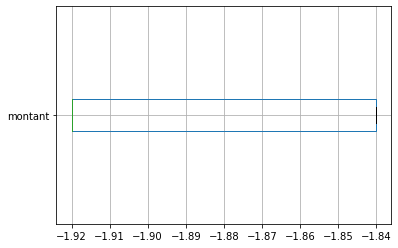

--------------------
RESTAURANT
moy:
 -10.332500000000001
med:
 -10.1
mod:
 0   -9.2
dtype: float64
var:
 2.853193750000001
ect:
 1.689139943876765
skw:
 -0.8883503487158837
kur:
 0.5988855591691937


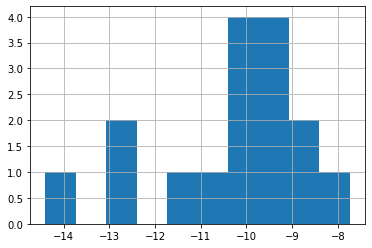

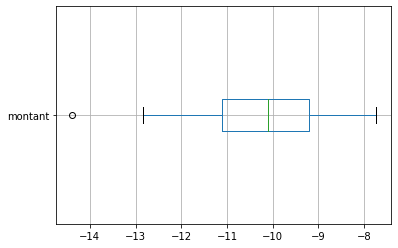

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
dtype: float64
var:
 0.0
ect:
 0.0
skw:
 0
kur:
 0


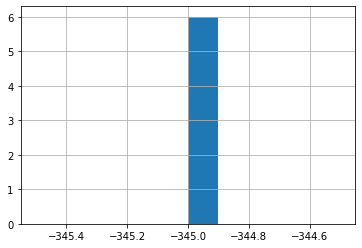

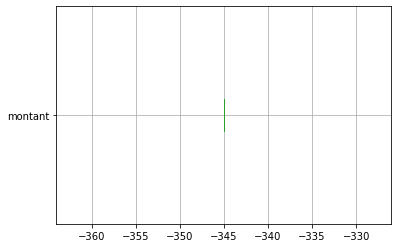

In [13]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    print("skw:\n",subset['montant'].skew())
    print("kur:\n",subset['montant'].kurtosis())
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

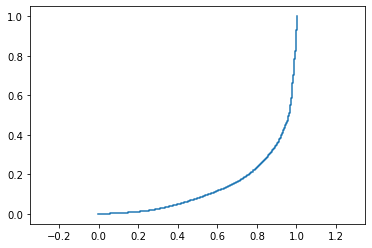

In [14]:
import numpy as np

depenses = data[data['montant'] < 0]
dep = -depenses['montant'].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.show()

In [15]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.7204386813739185

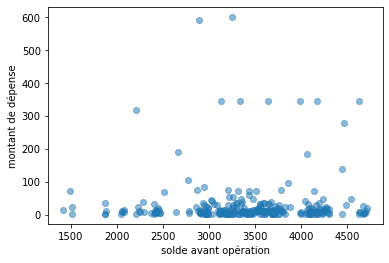

In [16]:
import matplotlib.pyplot as plt

depenses = data[data.montant < 0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],'o',alpha=0.5)
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

In [17]:
import scipy.stats as st
import numpy as np

print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])
print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

0.014536146489774634
705.0942213554406


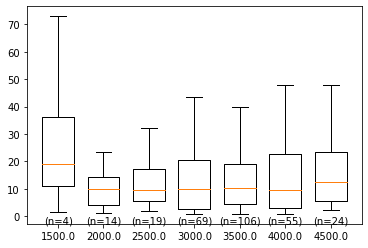

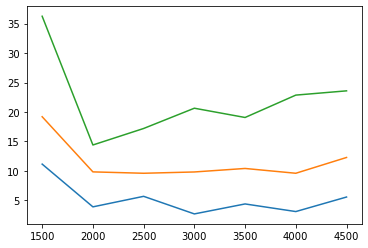

In [18]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"] # sélection des individus de la tranche ind
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7, # largeur graphique des boxplots
)

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

# affichage des quartiles
for n_quartile in range(3):
    plt.plot([g["centre_classe"] for g in groupes],
             [g["quartiles"][n_quartile] for g in groupes])
plt.show()

In [19]:
import datetime as dt

# Selection du sous-échantillon
courses = data[data.categ == "COURSES"]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})

In [21]:
import statsmodels.api as sm
Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

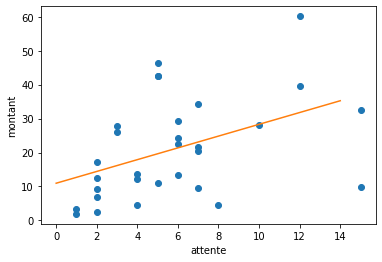

In [22]:
plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()